In [76]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from Models.struc.resnet import getResNetModel
import torch.nn as nn
import matplotlib.pyplot as plt

In [77]:
train = datasets.MNIST("./Images", 
                       True,
                       transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("./Images",
                      False,
                      transforms.Compose([transforms.ToTensor()]))
train = DataLoader(train, 128, True, num_workers=4)
test_data_loader = DataLoader(test, 128, True, num_workers=4)
test_eval = DataLoader(test, 1, True, num_workers=4)

In [78]:
blur = torchvision.transforms.GaussianBlur(5, 2)
train_data = []
for data, label in train:
    blur_data = blur(data)
    train_data.append((data, blur_data, label))

In [79]:
blur = torchvision.transforms.GaussianBlur(5, 2)
test_data = []
for data, label in test_data_loader:
    blur_data = blur(data)
    test_data.append((data, blur_data, label))

In [80]:
blur = torchvision.transforms.GaussianBlur(5, 2)
test_eval_data = []
for data, label in test_eval:
    blur_data = blur(data)
    test_eval_data.append((data, blur_data, label))

In [81]:
device = torch.device("mps")

In [82]:
class Deblur1Chan(nn.Module):
    def __init__(self):
        super(Deblur1Chan, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model_1 = Deblur1Chan().to(device)

In [83]:
class Deblur3Chan(nn.Module):
    def __init__(self):
        super(Deblur3Chan, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model_3 = Deblur3Chan().to(device)

In [84]:
opt = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        opt,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )
epochs = 30

In [85]:
for i in range(epochs):
    model_1.train()
    epoch_loss = 0
    for data, blur, label in train_data:
        data = data.to(device)
        blur = blur.to(device)
        label = label.to(device)

        opt.zero_grad()
        pred = model_1(blur)
        loss = F.mse_loss(pred, data)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    training_loss = epoch_loss/len(train_data)
    print(training_loss)


0.006310768535426224
0.0013806139812000526
0.0010068266756032337
0.0008376022018412792
0.0007422127940161809
0.000664498606102982
0.0006034377713385882
0.0005512709501258997
0.000511255383100321
0.00047769435518321945
0.00045954579057277186
0.0004287480013886852
0.0004156420538167177
0.0003941209563838521
0.0003793648177775731
0.0003660683544215633
0.00035152293480823494
0.00034170768089415726
0.00032955083070444004
0.0003227021016834824
0.00030880337669156685
0.0003046304301998175
0.00029198847395101827
0.0002884514552768447
0.00028247023269391134
0.00027697701125652954
0.00027202921958619365
0.0002664673339904669
0.0002630150873898598
0.00025686903526313476


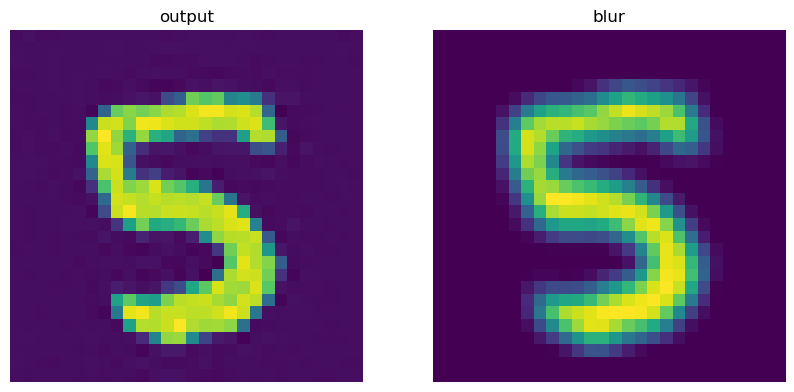

In [86]:
model_1.eval()
i = 0
for data, blur, label in test_eval_data:
    blur = blur.to(device)
    output = model_1(blur)
    fig = plt.figure(figsize=(10, 10))
    # Adds a subplot at the 1st position
    fig.add_subplot(1, 2, 1)
  
    # showing image
    plt.imshow(output.cpu().detach().squeeze())
    plt.axis('off')
    plt.title("output")
  
    # Adds a subplot at the 2nd position
    fig.add_subplot(1, 2, 2)
    # showing image
    plt.imshow(blur.cpu().detach().squeeze())
    plt.axis('off')
    plt.title("blur")
  

    if i == 0:
        break